# Baum - Welch Reparameterization

A popular classic method in the HMM literature for inferring model parameters is the *Expectation-Maximization* algorithm. The primary tools needed for this mode of estimation is simply the forward and backward probabilities ($P(x_t|Y^{[0, t]})$ and $P(x_t|Y^{[t, T]})$, respectively) that we have already built up the necessary logic to estimate. In the context of HMMs, the expectation-maximization algorithm is referred to as the *Baum-Welch* optimization algorithm.

In general an expectation-maximization algorithm is an iterative method for performing maximum likelihood estimation when some of the data are missing. This method exploits the fact that the *Complete-Data Log-Likelihood* (CDLL) may be straightforward to maximize, even if the likelihood of the observed data is not.  Here, the CDLL is simply the true log-likelihood function of parameters $\theta$ based on both the observed and missing data.

Informally, the algorithm can be described as follows: start witih an initial guess for the paramerer vector $\theta_i$ and then iterate the following two steps until the desired convergence is reached:

- ***Expectation***: Compute conditional expectation values of the missing data given the observed data and the current estimate of parameters ($\theta$). Or, precisely, compute the conditional expectations of those functions of missing data that appear in the CDLL
- ***Maximization***: Maximize (with respect to $\theta$) the CDLL with the functions of the missing data replaced with their conditional expectations.

By iterating this process, the parameter vector will converge towards a local maximum of the likelihood function

known as the *Baum-Welch* algorithm, and is a particular instance of an Expectation-Maximization algorithm. While this algorithm still seeks to find the maximum likelihood solution to the problems introduced earlier, the procedure is slightly different, and can better solve for a unique minimum, while scaling better at times with dimensions.

Specifically, the BW algorithm (like all EM algorithms) takes place over two steps, which are iterated over until a convergence criteria has been reached. Those steps are:
- **Expectation**: calculate the most probable set of hidden states given a set of parameters
- **Maximization**: Assuming the hidden state sequence in the previous step is correct, what is the maximum likelihood set of transition parameters

Unlike the previous naive likelihood maximization, this algorithm works by first calculating the maximum likelihood (Bayesian) estimate of the hidden state given the observed sequence of states (assuming fixed transition $A$ and observation $B$ matrices):

$$ \gamma_i^t \equiv P(x_t = i| Y^T)$$

where $\gamma_i^t$ represents the probability of the hidden state being in state $i$ at time $t$, given the entire history of observations $Y^T$ (from $t=0 \to N$).

This represents the *expectation* step. Next, we update the parameters of the $A$ and $B$ matrix in the following way:

First, we calculate the transition probability of hidden state transitions, given all observations:

$$ \xi_t^{ji} \equiv P(x_t = i, x_{t+1} = j | Y^T ) = P(x_t = i | Y^{[0, t]})P(x_t = i, x_{t+1} = j)P(x_{t+1} = j | Y^{[t+1, T]} )P(y_{t+1} = j | x_{t=1} = j) $$

From this equation, we already know a few terms: $P(x_t = i| Y^{[0, t]})$ is simply the forward probability at tiem step $t$, similarly $P(x_{t+1} = j | Y^{[t+1, T]})$ is the backward probability at time $t+1$, the last term $P(y_{t+1} = j| X_{t+1} = j)$ is just the matrix element $B_{jj}$ of the observation matrix. Therefore, to determine $\xi_t^{ij}$, we just need to determine the middle term $P(x_t = i, x_{t+1} = j)$. However, this middle term is just the matrix element $A_{ij}$: the probability of a transition from $x_i \to x_j$. Therefore, we have the entire expression built from terms already at our disposal.

Once we have this $\xi_t^{ji}$ term, we update the transition matrix elements as

$$ A_{ij}^* = \frac{\sum_{t=1}^T \xi_t^{ij} }{\sum_{t=1}^T \gamma_i^t } $$

which is simply the expecten number of transitions $i\to j$ divided by the number of times that the system was in state $i$.
This provides the logic for updating the transition matrix terms, the remaining piece is to update the observation matrix terms.  Here, we set

$$ B_{ij}^* =  \frac{\sum_{t=1}^T \mathcal{I}[y_t = i]\gamma_j^t}{\sum_{t=1}^T \gamma_j^t}$$

Which can alternatively be written as

$$ B_{ij}^* = \frac{\sum_{t | y_t = i} \gamma_i^t}{\sum_{t=1}^T \gamma_i^t} $$ 

Which, intuitively, serves as a measure of the relative probability of being in state $i$ when the obervation is $i$.

For each of these expressions there are $N\times N$ terms to evaluate.



In [2]:
# First, import the necessary modules
import os
import numpy as np
from typing import Iterable, Optional, Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="hls")

from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.1
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [3]:
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(1000)
obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

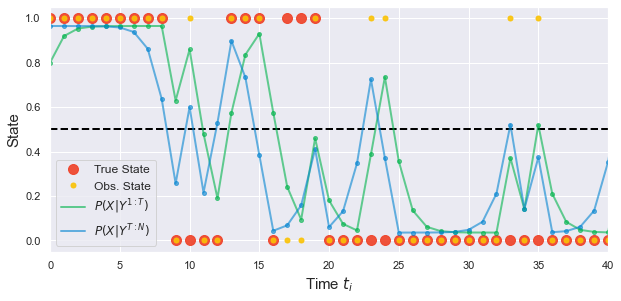

In [4]:
bayes_infer = infer.MarkovInfer(2, 2)

# First, we can check the forward and backward algorithms to be sure that there are no off-by-one errors
bayes_infer.forward_algo(obs_ts, A, B)
bayes_infer.backward_algo(obs_ts, A, B)

# Prediction of the forward and backward algorithms at each point in time
fwd_pred = [np.argmax(i) for i in bayes_infer.forward_tracker]
bak_pred = [np.argmax(i) for i in bayes_infer.backward_tracker]

# Probabilities of the system being in state 1
fwd_prob_one = [i[1] for i in bayes_infer.forward_tracker]
bak_prob_one = [i[1] for i in bayes_infer.backward_tracker]

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k')

ax.plot(state_ts, 'o', markersize=10, color=sns.xkcd_rgb["tomato"], alpha=0.9, label="True State")
ax.plot(obs_ts, 'o', markersize=5, color=sns.xkcd_rgb["goldenrod"], alpha=0.9, label="Obs. State")

ax.plot(fwd_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], alpha=0.6)
ax.plot(bak_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], alpha=0.6)

ax.plot(fwd_prob_one, linewidth=2.0, color=sns.xkcd_rgb["shamrock"], alpha=0.6, label=r"$P(X|Y^{1:T})$")
ax.plot(bak_prob_one, linewidth=2.0, color=sns.xkcd_rgb["cerulean"], alpha=0.6, label=r"$P(X|Y^{T:N})$")

ax.set_xlim([0,40])
ax.set_xlabel(r"Time $t_i$", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, ncol=1, frameon=True)

In [5]:
bayes_infer.bayesian_smooth(A)


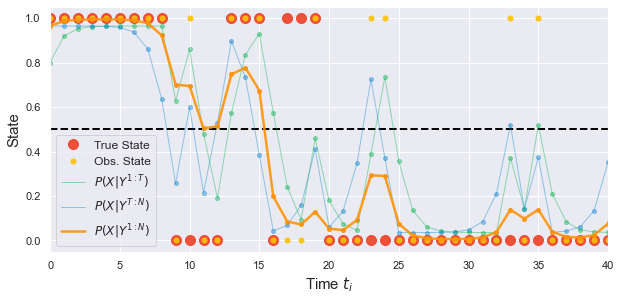

In [6]:
smooth_prob_one = [i[1] for i in bayes_infer.bayes_smoother]

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k')

ax.plot(state_ts, 'o', markersize=10, color=sns.xkcd_rgb["tomato"], alpha=0.9, label="True State")
ax.plot(obs_ts, 'o', markersize=5, color=sns.xkcd_rgb["goldenrod"], alpha=0.9, label="Obs. State")

ax.plot(fwd_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], alpha=0.4)
ax.plot(bak_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], alpha=0.4)
ax.plot(smooth_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], alpha=0.9)

ax.plot(fwd_prob_one, linewidth=1.0, color=sns.xkcd_rgb["shamrock"], alpha=0.4, label=r"$P(X|Y^{1:T})$")
ax.plot(bak_prob_one, linewidth=1.0, color=sns.xkcd_rgb["cerulean"], alpha=0.4, label=r"$P(X|Y^{T:N})$")
ax.plot(smooth_prob_one, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], alpha=0.9, label=r"$P(X|Y^{1:N})$")

ax.set_xlim([0,40])
ax.set_xlabel(r"Time $t_i$", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, ncol=1, frameon=True)


In [7]:
# Here, we can see that the smoother estimate gets most inferrences right (at
# least for this window slice), while both the forward, and backward algorithms
# get some wrong. The smoother gets fooled by the quick state switch around t=15
# but not on either end of the more prolonged state switch around t=20 - 26

pred_smooth = [np.argmax(i) for i in bayes_infer.bayes_smoother]


def error_rate(pred: Iterable, real: Iterable) -> float:
    return 1 - np.mean([p == s for p, s in zip(pred, real)])


print(f"Error (Fwd)    : {error_rate(fwd_pred, state_ts)}")
print(f"Error (Back)   : {error_rate(bak_pred, state_ts)}")
print(f"Error (Smooth) : {error_rate(pred_smooth, state_ts)}")

Error (Fwd)    : 0.18400000000000005
Error (Back)   : 0.17300000000000004
Error (Smooth) : 0.129


In [30]:
# So, we can see that the smoother has the lowest total overall
# error (as expected, because it uses ALL available information,
#  future and past)


In [13]:
# Now, for the Baum-Welch optimization process, for an initial starting guess
# at parameters, we calculate the Bayesian smoothed estimate for the states
# and assume them to be accurate, and then use those (assumedly known) states
# as fixed in the subsequent optimization of the likelihood function

# First, we will define an 'ExpctationResult' class that will serve as an
# intermediate interface with the EM algo


class ExpectationResult:
    def __init__(
        self, bayes_smooth: np.ndarray, bayes_fwd: np.ndarray,
        bayes_back: np.ndarray, A: np.ndarray, B: np.ndarray
    ):
        self.__gamma = bayes_smooth
        self.__alpha = bayes_fwd
        self.__beta = bayes_back
        self.__A = A
        self.__B = B

    @property
    def gamma(self):
        return self.__gamma

    @property
    def alpha(self):
        return self.__alpha

    @property
    def beta(self):
        return self.__beta

    @property
    def A(self):
        return self.__A

    @property
    def B(self):
        return self.__B

    def alpha_i(self, i: int):
        return np.array([elem[i] for elem in self.__alpha])

    def beta_i(self, i: int):
        return np.array([elem[i] for elem in self.__beta])

    def gamma_i(self, i: int):
        return np.array([elem[i] for elem in self.__gamma])

# First we define the 'expectation' step (which is the bayesian smoother part)
def expectation(
    bayes_infer: any, obs_ts: Iterable, A_est: np.ndarray, B_est: np.ndarray
) -> Iterable: 
    bayes_infer.forward_algo(obs_ts, A_est, B_est)
    bayes_infer.backward_algo(obs_ts, A_est, B_est)
    bayes_infer.bayesian_smooth(A_est)
    # This is the gamma_i^t term
    return ExpectationResult(
        bayes_infer.bayes_smoother,
        bayes_infer.forward_tracker,
        bayes_infer.backward_tracker,
        A_est, B_est
    )

In [15]:
# We can test this out:
e_res = expectation(bayes_infer, obs_ts, A, B)
e_res.alpha_i(0)[:10], e_res.alpha_i(1)[:10]

(array([0.2       , 0.08074534, 0.0469442 , 0.03834473, 0.03621862,
        0.03569671, 0.03556882, 0.03553749, 0.03552982, 0.37082651]),
 array([0.8       , 0.91925466, 0.9530558 , 0.96165527, 0.96378138,
        0.96430329, 0.96443118, 0.96446251, 0.96447018, 0.62917349]))

Now, we can calculate the $xi_{ji}^t$ term, which is, quantitatively

$$ \xi_t^{ji} = P(x_t = i | Y^{[0, t]})P(x_t = i, x_{t+1} = j)P(x_{t+1} = j | Y^{[t+1, T]} )P(y_{t+1} = j | x_{t=1} = j) $$

Which, for $\alpha_i^t \equiv P(x_t = i | Y^{[0, t]})$, $\beta_i^t \equiv P(x_t = i | Y^{[t, T]})$ (which serve as common notation for the firward and backward terms in much of the literature)as well as noting that $P(y_{t+1} = j | x_{t=1} = j) = B_{jj}$, we can write the term more concisely as

$$ \xi_{ji}^t = \alpha_i^t A_{ji} \beta_j^{t+1} B_{jj}$$

In [10]:
# So, this can be calcualted for each i, j

def calc_xi_term(exp: ExpectationResult, sys_dim: int) -> np.ndarray:
    xi = np.zeros((sys_dim, sys_dim))
    for i in sys_dim:
        for j in sys_dim:
            xi[j, i] = [exp.alpha[:-1]] * exp.A[j, i] * exp.beta[1:]

e_res.gamma


[array([0.03553328, 0.96446672]),
 array([0.01278596, 0.98721404]),
 array([0.00722606, 0.99277394]),
 array([0.00590945, 0.99409055]),
 array([0.0057709, 0.9942291]),
 array([0.00648784, 0.99351216]),
 array([0.0097294, 0.9902706]),
 array([0.02304233, 0.97695767]),
 array([0.07742081, 0.92257919]),
 array([0.29946471, 0.70053529]),
 array([0.30516236, 0.69483764]),
 array([0.49631775, 0.50368225]),
 array([0.48650604, 0.51349396]),
 array([0.25288434, 0.74711566]),
 array([0.2227125, 0.7772875]),
 array([0.32574673, 0.67425327]),
 array([0.80186355, 0.19813645]),
 array([0.91486732, 0.08513268]),
 array([0.92784495, 0.07215505]),
 array([0.87101, 0.12899]),
 array([0.94639818, 0.05360182]),
 array([0.95342324, 0.04657676]),
 array([0.90844039, 0.09155961]),
 array([0.70672397, 0.29327603]),
 array([0.70980085, 0.29019915]),
 array([0.92483436, 0.07516564]),
 array([0.97749211, 0.02250789]),
 array([0.99036792, 0.00963208]),
 array([0.99343827, 0.00656173]),
 array([0.99385131, 0.0061

In [68]:
# Next, the 'maximization' step which is simply the likelihood maximization,
# under the assumption that the smoother estimates are completely accurate
import scipy.optimize as so

# Helper function to extract parameters and build A, B matrices
def _extract_hmm_parameters(theta: Iterable):
    A = theta[0] * np.ones((2, 2))
    B = theta[1] * np.ones((2, 2))

    A[0, 0], A[1, 1] = 1 - theta[0], 1 - theta[0]
    B[0, 0], B[1, 1] = 1 - theta[1], 1 - theta[1]

    return A, B

# Likelihood function for Baum-Welch algorithm (known state time series)
def calc_likelihood_BW(
    param_arr: Iterable, obs_ts: Iterable,
    state_ts: Iterable
) -> float:
        _, B = _extract_hmm_parameters(param_arr)
        likelihood = 0
        for state, obs in zip(state_ts, obs_ts):
            inner = state @ B[:, obs]
            likelihood -= np.log(inner)
        return likelihood

# Optimization routine for likelihood
def optimize_likelihood(
    obs_ts: Iterable, param_init: Iterable,
    state_ts: Iterable
):
    lower_lim = 1e-3
    upper_lim = 1 - 1e-3
    bnds = [(lower_lim, upper_lim)] * len(param_init)

    res = so.minimize(
        calc_likelihood_BW, param_init,
        args=(obs_ts, state_ts), method="SLSQP", bounds=bnds,
        tol=1e-10
    )

    return res

def maximization(
    obs_ts: Iterable, pred_ts: Iterable,
    param_init: np.ndarray
):
    opt_result = optimize_likelihood(
        obs_ts, param_init, pred_ts
    )
    param_opt = opt_result.x
    final_likelihood = opt_result.fun
    return param_opt, final_likelihood



In [69]:
# To start, we can look at estimted A and B matrices
A_est = np.array([[0.85, 0.15],[0.15, 0.85]])
B_est = np.array([[0.85, 0.15],[0.15, 0.85]])
param_init = [0.15, 0.15]

# Now, generate the set of predicted states from the smoother
print("Running Expectation step...")
state_pred = expectation(bayes_infer, obs_ts, A_est, B_est)
print("Runnning Maximization step...")
param_opt = maximization(obs_ts, state_pred, param_init)


Running Expectation step...
Runnning Maximization step...


In [70]:
# We can then iterate over this process many times to find the optimal solution
likelihood_tracker = []
param_tracker = []

param_arr = [0.15, 0.15]
for i in range(15):
    A_est = param_arr[0] * np.ones((2, 2))
    B_est = param_arr[1] * np.ones((2, 2))
    A_est += np.eye(2) - 2 * param_arr[0]
    B_est += np.eye(2) - 2 * param_arr[1]

    state_pred = expectation(bayes_infer, obs_ts, A_est, B_est)
    param_opt, likely = maximization(obs_ts, state_pred, param_arr)
    param_arr = param_opt
    param_tracker.append(param_arr)
    likelihood_tracker.append(likely)


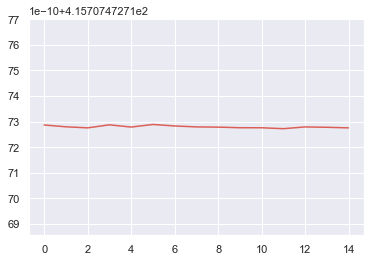

In [71]:
plt.plot(likelihood_tracker)

In [72]:
param_tracker

[array([0.15      , 0.14600001]),
 array([0.15      , 0.14600002]),
 array([0.15      , 0.14600001]),
 array([0.15      , 0.14600001]),
 array([0.15      , 0.14599998]),
 array([0.15      , 0.14599998]),
 array([0.15      , 0.14599998]),
 array([0.15      , 0.14600003]),
 array([0.15      , 0.14600002]),
 array([0.15      , 0.14599999]),
 array([0.15      , 0.14599999]),
 array([0.15      , 0.14599999]),
 array([0.15      , 0.14599999]),
 array([0.15      , 0.14599999]),
 array([0.15      , 0.14599999])]